In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (96).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (5).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (81).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (30).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (63).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (51).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (64).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (33).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (89).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (45).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (98).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (70).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (27).mp4
/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (35).mp4
/kaggle

In [2]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2025-06-21 13:32:51.275914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750512771.557676      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750512771.642654      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False


x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  
inception_model = Model(inputs=base_model.input, outputs=x)

2025-06-21 13:33:08.605314: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [5]:
import cv2
import numpy as np
import os

from tensorflow.keras.applications.inception_v3 import preprocess_input
def extract_video_features(video_path, feature_extractor, frame_step=5, target_size=(299, 299)):
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None

    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id % frame_step == 0:
            frame = cv2.resize(frame, target_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = preprocess_input(frame.astype(np.float32))
            frames.append(frame)
        frame_id += 1

    cap.release()

    if not frames:
        print("Warning: No frames extracted from video.")
        return None
        
    frames = np.array(frames, dtype=np.float32)
    features = feature_extractor.predict(frames, verbose=0)
    return features  # (num_frames, feature_dim)
# Path to video file
video_path = "/kaggle/input/test-set/testing dataset/distracted behavior/Distracted (11).mp4"

video_features = extract_video_features(video_path, inception_model)

if video_features is not None:
    print("Extracted Features Shape:", video_features.shape)  # Should be (num_frames, feature_dim)
else:
    print("Feature extraction failed.")

Extracted Features Shape: (83, 256)


In [6]:
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np

dataset_path = "/kaggle/input/test-set"
video_dir = os.path.join(dataset_path, "testing dataset")
label_map = {"normal behavior": 0, "distracted behavior": 1}

video_paths = []
labels = []

for class_name, label in label_map.items():
    class_folder = os.path.join(video_dir, class_name)
    for filename in os.listdir(class_folder):
        if filename.endswith((".mp4", ".avi", ".mov")):
            video_paths.append(os.path.join(class_folder, filename))
            labels.append(label)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print("Label Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Label Mapping: {0: 0, 1: 1}


In [7]:
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels, val_labels = train_test_split(
    video_paths, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42
)

In [8]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence_length = 50

def extract_features_batch(video_paths, labels, model, max_sequence_length):
    data = []
    processed_labels = []

    for video_path, label in zip(video_paths, labels):
        print(f"Processing: {video_path}")
        features = extract_video_features(video_path, model)
        if features is not None:
            padded_features = pad_sequences(
                [features], maxlen=max_sequence_length,
                dtype='float32', padding='post', truncating='post'
            )[0]
            data.append(padded_features)
            processed_labels.append(label)

    return np.array(data), np.array(processed_labels)

x_train, y_train = extract_features_batch(train_paths, train_labels, inception_model, max_sequence_length)
x_val, y_val = extract_features_batch(val_paths, val_labels, inception_model, max_sequence_length)


Processing: /kaggle/input/test-set/testing dataset/distracted behavior/Distracted (48).mp4
Processing: /kaggle/input/test-set/testing dataset/distracted behavior/Distracted (75).mp4
Processing: /kaggle/input/test-set/testing dataset/normal behavior/NORMAL (74).mp4
Processing: /kaggle/input/test-set/testing dataset/distracted behavior/Distracted (80).mp4
Processing: /kaggle/input/test-set/testing dataset/distracted behavior/Distracted (55).mp4
Processing: /kaggle/input/test-set/testing dataset/distracted behavior/Distracted (22).mp4
Processing: /kaggle/input/test-set/testing dataset/distracted behavior/Distracted.mp4
Processing: /kaggle/input/test-set/testing dataset/normal behavior/NORMAL (18).mp4
Processing: /kaggle/input/test-set/testing dataset/normal behavior/NORMAL (70).mp4
Processing: /kaggle/input/test-set/testing dataset/distracted behavior/Distracted (53).mp4
Processing: /kaggle/input/test-set/testing dataset/normal behavior/NORMAL (67).mp4
Processing: /kaggle/input/test-set/t

[hevc @ 0x1c1b7a40] Invalid NAL unit size (0 > 19751).
[hevc @ 0x1c1b7a40] Error splitting the input into NAL units.
[hevc @ 0x219f6ac0] Invalid NAL unit size (0 > 9058).
[hevc @ 0x219f6ac0] Error splitting the input into NAL units.
[hevc @ 0x206f2340] Invalid NAL unit size (0 > 9529).
[hevc @ 0x206f2340] Error splitting the input into NAL units.
[hevc @ 0x21ae0f80] Invalid NAL unit size (0 > 65968).
[hevc @ 0x21ae0f80] Error splitting the input into NAL units.


Processing: /kaggle/input/test-set/testing dataset/distracted behavior/Distracted (47).mp4
Processing: /kaggle/input/test-set/testing dataset/normal behavior/NORMAL (17).mp4
Processing: /kaggle/input/test-set/testing dataset/distracted behavior/Distracted (54).mp4
Processing: /kaggle/input/test-set/testing dataset/normal behavior/NORMAL (89).mp4
Processing: /kaggle/input/test-set/testing dataset/distracted behavior/Distracted (31).mp4
Processing: /kaggle/input/test-set/testing dataset/normal behavior/NORMAL (96).mp4
Processing: /kaggle/input/test-set/testing dataset/normal behavior/NORMAL (25).mp4
Processing: /kaggle/input/test-set/testing dataset/normal behavior/NORMAL (88).mp4
Processing: /kaggle/input/test-set/testing dataset/normal behavior/NORMAL (49).mp4
Processing: /kaggle/input/test-set/testing dataset/distracted behavior/Distracted (72).mp4
Processing: /kaggle/input/test-set/testing dataset/normal behavior/NORMAL (20).mp4
Processing: /kaggle/input/test-set/testing dataset/norm

In [9]:
inception_model.save('cnnModel.h5')

In [10]:
print(x_train.shape)
print(x_val.shape)

(168, 50, 256)
(42, 50, 256)


In [11]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))


input_shape = [50, 256]
lstm_input = layers.Input(shape=input_shape, name='feature_input')
lstm = layers.LSTM(50)(lstm_input)
cls_out = layers.Dense(1, activation='sigmoid')(lstm)
lstmModel = Model(inputs=lstm_input, outputs=cls_out)
lstmModel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_LOR    =  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# Train Model
history = lstmModel.fit(
    x_train, y_train,
    validation_data=(x_val,y_val),
    batch_size=16,
    epochs=70,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.4410 - loss: 0.7053 - val_accuracy: 0.4286 - val_loss: 0.6913
Epoch 2/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5442 - loss: 0.6790 - val_accuracy: 0.5000 - val_loss: 0.6683
Epoch 3/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5573 - loss: 0.6829 - val_accuracy: 0.5714 - val_loss: 0.6589
Epoch 4/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6031 - loss: 0.6659 - val_accuracy: 0.5952 - val_loss: 0.6481
Epoch 5/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6716 - loss: 0.6485 - val_accuracy: 0.6667 - val_loss: 0.6382
Epoch 6/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6440 - loss: 0.6416 - val_accuracy: 0.6667 - val_loss: 0.6229
Epoch 7/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6874 - loss: 0.6079 - val_accuracy: 0.7143 - val_loss: 0.6089
Epoch 8/70
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6851 - loss: 0.6007 - val_accuracy: 0.6905 - v

In [12]:
lstmModel.save('/kaggle/working/lstmModelfinal.keras')  # or .h5 in older versions

In [13]:

def predict_video_class(video_path, feature_extractor, lstmmodel, label_encoder, max_sequence_length=50):
    features = extract_video_features(video_path, feature_extractor)
    if features is None:
        print("Feature extraction failed.")
        return None

    padded = pad_sequences([features], maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')
    prediction = lstmmodel.predict(padded, verbose=0)

    print("Prediction vector:", prediction)
    predicted_class = int(prediction[0][0] > 0.5)  # Threshold at 0.5
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    print(f"Predicted class: {predicted_label}")
    return predicted_label

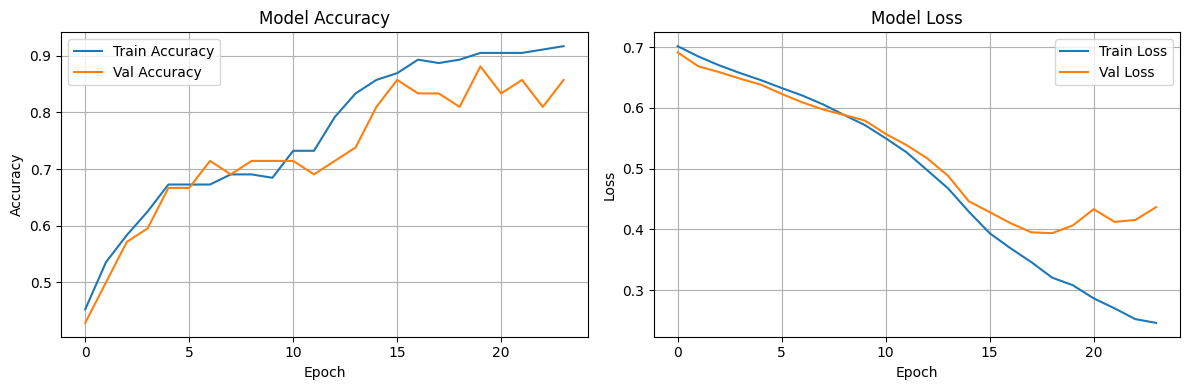

In [14]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
video_path = "/kaggle/input/test-set/testing dataset/distracted behavior/Distracted (80).mp4" 

predicted_video_class = predict_video_class(
    video_path=video_path,
    feature_extractor=inception_model,   # your InceptionV3 or other CNN
    lstmmodel=lstmModel,
    label_encoder=label_encoder,           
    max_sequence_length=50
)

Prediction vector: [[0.93980664]]
Predicted class: 1


In [16]:
video_path = "/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (80).mp4" 

predicted_video_class = predict_video_class(
    video_path=video_path,
    feature_extractor=inception_model,   # your InceptionV3 or other CNN
    lstmmodel=lstmModel,
    label_encoder=label_encoder,           
    max_sequence_length=50
)

Prediction vector: [[0.26030838]]
Predicted class: 0


In [17]:
video_path = "/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (5).mp4" 

predicted_video_class = predict_video_class(
    video_path=video_path,
    feature_extractor=inception_model,   # your InceptionV3 or other CNN
    lstmmodel=lstmModel,
    label_encoder=label_encoder,           
    max_sequence_length=50
)

Prediction vector: [[0.5042121]]
Predicted class: 1


In [18]:
video_path = "/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (15).mp4" 

predicted_video_class = predict_video_class(
    video_path=video_path,
    feature_extractor=inception_model,   # your InceptionV3 or other CNN
    lstmmodel=lstmModel,
    label_encoder=label_encoder,           
    max_sequence_length=50
)

Prediction vector: [[0.4359114]]
Predicted class: 0


In [19]:
video_path = "/kaggle/input/test-set/testing dataset/normal behavior/NORMAL (100).mp4" 

predicted_video_class = predict_video_class(
    video_path=video_path,
    feature_extractor=inception_model,   # your InceptionV3 or other CNN
    lstmmodel=lstmModel,
    label_encoder=label_encoder,           
    max_sequence_length=50
)

Prediction vector: [[0.04222825]]
Predicted class: 0


In [20]:
video_path = "/kaggle/input/test-set/testing dataset/distracted behavior/Distracted (10).mp4" 

predicted_video_class = predict_video_class(
    video_path=video_path,
    feature_extractor=inception_model,   # your InceptionV3 or other CNN
    lstmmodel=lstmModel,
    label_encoder=label_encoder,           
    max_sequence_length=50
)

Prediction vector: [[0.5475786]]
Predicted class: 1


In [21]:
video_path = "/kaggle/input/test-set/testing dataset/distracted behavior/Distracted.mp4" 

predicted_video_class = predict_video_class(
    video_path=video_path,
    feature_extractor=inception_model,   # your InceptionV3 or other CNN
    lstmmodel=lstmModel,
    label_encoder=label_encoder,           
    max_sequence_length=50
)

Prediction vector: [[0.6892256]]
Predicted class: 1


In [22]:
video_path = "/kaggle/input/test-set/testing dataset/distracted behavior/Distracted (20).mp4" 

predicted_video_class = predict_video_class(
    video_path=video_path,
    feature_extractor=inception_model,   # your InceptionV3 or other CNN
    lstmmodel=lstmModel,
    label_encoder=label_encoder,           
    max_sequence_length=50
)

Prediction vector: [[0.8408872]]
Predicted class: 1


In [23]:
video_path = "/kaggle/input/test-set/testing dataset/distracted behavior/Distracted (30).mp4" 

predicted_video_class = predict_video_class(
    video_path=video_path,
    feature_extractor=inception_model,   # your InceptionV3 or other CNN
    lstmmodel=lstmModel,
    label_encoder=label_encoder,           
    max_sequence_length=50
)

Prediction vector: [[0.83560836]]
Predicted class: 1


In [24]:
video_path = "/kaggle/input/test-set/testing dataset/distracted behavior/Distracted (43).mp4" 

predicted_video_class = predict_video_class(
    video_path=video_path,
    feature_extractor=inception_model,   # your InceptionV3 or other CNN
    lstmmodel=lstmModel,
    label_encoder=label_encoder,           
    max_sequence_length=50
)

Prediction vector: [[0.54878944]]
Predicted class: 1


In [25]:
video_path = "/kaggle/input/test-set/testing dataset/distracted behavior/Distracted (3).mp4" 

predicted_video_class = predict_video_class(
    video_path=video_path,
    feature_extractor=inception_model,   # your InceptionV3 or other CNN
    lstmmodel=lstmModel,
    label_encoder=label_encoder,           
    max_sequence_length=50
)

Prediction vector: [[0.94533026]]
Predicted class: 1


In [26]:
import numpy as np

# Get model predictions
y_pred_probs = lstmModel.predict(x_val)

# For binary classification
y_pred = (y_pred_probs > 0.5).astype(int)

# For multi-class classification (if using softmax)
# y_pred = np.argmax(y_pred_probs, axis=1)
# y_test = np.argmax(y_test, axis=1)  # if one-hot encoded

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


In [27]:
from sklearn.metrics import f1_score, confusion_matrix

# F1 Score
f1 = f1_score(y_val, y_pred, average='binary')  # Use 'macro', 'micro', or 'weighted' for multi-class
print("F1 Score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)

F1 Score: 0.7999999999999999
Confusion Matrix:
 [[18  6]
 [ 2 16]]


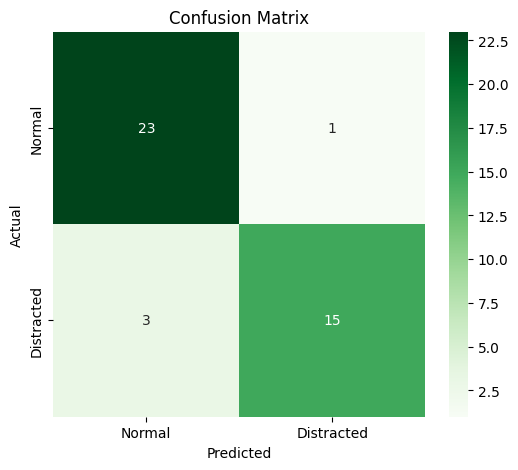

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Updated confusion matrix
cm = np.array([[23, 1],
               [3, 15]])

# Class labels (you can change them if needed)
labels = ["Normal", "Distracted"]

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'lstmModelfinal.keras',
    monitor='val_accuracy',  # or 'val_loss'
    save_best_only=True,
    mode='max',  # 'max' for accuracy, 'min' for loss
    verbose=1
)

lstmModel.fit(
    x_train, y_train,
    validation_data=[x_val, y_val],
    epochs=50,
    callbacks=[checkpoint]
)

Epoch 1/50
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9193 - loss: 0.2596
Epoch 1: val_accuracy improved from -inf to 0.85714, saving model to lstmModelfinal.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9107 - loss: 0.2823 - val_accuracy: 0.8571 - val_loss: 0.3935
Epoch 2/50
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9303 - loss: 0.3043
Epoch 2: val_accuracy did not improve from 0.85714
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9213 - loss: 0.3036 - val_accuracy: 0.8333 - val_loss: 0.4121
Epoch 3/50
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9004 - loss: 0.3097
Epoch 3: val_accuracy did not improve from 0.85714
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8990 - loss: 0.3029 - val_accuracy: 0.8333 - val_loss: 0.4168
Epoch 4/50
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9121 - loss: 0.2622
Epoch 4: val_accuracy did not improve from 0.85714
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9109 - loss: 0.2702 - val_accur

In [30]:
lstmModel.save('/kaggle/working/best_model.keras')